## How minimizing one dimension of human bias affects other bias dimensions even if it was unintended


### Methodology:

Comparing dimensions of bias in the Alpaca instruction dataset with OccuQuest (an instruction dataset that minimized occupational bias) to see what this improved in one bias dimension may have done to the other bias dimensions.

Using the SBERT model for sentence embeddings and WEAT effect size to quantify the strength of association between concepts and sensitive attributes related to gender, racial and age bias.


Questions: jonathan.bennion@gmail.com

In [10]:
# setup
!pip install -q --upgrade datasets==2.14.5 matplotlib==3.7.2 numpy==1.23.5 huggingface_hub sentence-transformers==2.2.2 scipy==1.10.1 tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 436.4/436.4 kB 6.8 MB/s eta 0:00:00


In [55]:
import random
import matplotlib.pyplot as plt
import numpy as np
from sentence_transformers import SentenceTransformer
from scipy import stats
from huggingface_hub import notebook_login
from datasets import load_dataset
import json
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

In [12]:
# auth to HF
from huggingface_hub import login
from getpass import getpass

def huggingface_login():
    print("Please enter your HF API token.")
    token = getpass("Token: ")
huggingface_login()

Please enter your HF API token.
Token: ··········


In [14]:
# Load SBERT model
model = SentenceTransformer('all-MiniLM-L6-v2')


.gitattributes:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

data_config.json:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

model.onnx:   0%|          | 0.00/90.4M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

train_script.py:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

In [16]:
# Load datasets for compare
try:
    occuquest = load_dataset("OFA-Sys/OccuQuest", split="train")
    alpaca = load_dataset("tatsu-lab/alpaca", split="train")
except Exception as e:
    print(f"Error w load: {e}")
    raise

Extracting data files:   0%|          | 0/6 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/114090 [00:00<?, ? examples/s]

Generating dialog split:   0%|          | 0/31682 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2500 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/250 [00:00<?, ? examples/s]

Generating estate split:   0%|          | 0/250 [00:00<?, ? examples/s]

Generating quora split:   0%|          | 0/250 [00:00<?, ? examples/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [17]:
# Sample size function in order for efficiency to occur here
def calculate_sample_size(effect_size, alpha=0.05, power=0.8):
    z_alpha = stats.norm.ppf(1 - alpha/2)
    z_beta = stats.norm.ppf(power)
    sample_size = ((z_alpha + z_beta) / effect_size) ** 2
    return int(np.ceil(sample_size))

In [46]:
# Calculate sample size
effect_size = 0.1  # Small effect size
alpha = 0.05  # Significance level
power = 0.8  # Desired power

sample_size = calculate_sample_size(effect_size, alpha, power)
print(f"Sample size for an effect size of 0.1: {sample_size}")

Sample size for an effect size of 0.1: 785


In [47]:
# Sample from datasets
occuquest_sample = occuquest.shuffle(seed=42).select(range(sample_size))
alpaca_sample = alpaca.shuffle(seed=42).select(range(sample_size))

In [48]:
print(occuquest_sample)

Dataset({
    features: ['category', 'occupation', 'topic', 'messages'],
    num_rows: 785
})


In [23]:
# Define bias categories and associated words - this is just to test attribute mappings to targets
bias_categories = {
    'gender_bias': {
        'target_1': ['man', 'male', 'boy', 'brother', 'he', 'him', 'his', 'son'],
        'target_2': ['woman', 'female', 'girl', 'sister', 'she', 'her', 'hers', 'daughter'],
        'attribute_1': ['career', 'professional', 'corporation', 'salary', 'office', 'business', 'job'],
        'attribute_2': ['home', 'parents', 'children', 'family', 'cousins', 'marriage', 'wedding']
    },
    'racial_bias': {
        'target_1': ['european', 'caucasian', 'white'],
        'target_2': ['african', 'black', 'negro'],
        'attribute_1': ['pleasant', 'peace', 'wonderful', 'joy', 'love', 'happy', 'laughter', 'health'],
        'attribute_2': ['unpleasant', 'agony', 'terrible', 'horrible', 'evil', 'hurt', 'sick', 'failure']
    },
    'age_bias': {
        'target_1': ['young', 'youth', 'teenager', 'adolescent'],
        'target_2': ['old', 'elderly', 'senior', 'aged'],
        'attribute_1': ['active', 'energetic', 'lively', 'quick', 'sharp'],
        'attribute_2': ['slow', 'tired', 'passive', 'sluggish', 'weak']
    },
    'occupation_bias': {
        'target_1': ['manager', 'executive', 'CEO', 'boss'],
        'target_2': ['assistant', 'secretary', 'clerk', 'receptionist'],
        'attribute_1': ['competent', 'capable', 'skilled', 'efficient', 'professional'],
        'attribute_2': ['incompetent', 'incapable', 'unskilled', 'inefficient', 'unprofessional']
    }
}


In [51]:
# Functions for cosine similarity and WEAT to measure differences - note other distance functions are likely better

def cosine_similarity_matrix(A, B):
    # Compute cosine similarity between each row of A and each row of B
    norm_A = np.linalg.norm(A, axis=1, keepdims=True)
    norm_B = np.linalg.norm(B, axis=1, keepdims=True)
    return np.dot(A / norm_A, (B / norm_B).T)

def weat_effect_size_batch(W, A, B, X, Y):
    # Compute cosine similarities
    s_W_A = np.mean(cosine_similarity_matrix(W, A), axis=1)
    s_W_B = np.mean(cosine_similarity_matrix(W, B), axis=1)
    s_X_A = np.mean(cosine_similarity_matrix(X, A))
    s_X_B = np.mean(cosine_similarity_matrix(X, B))
    s_Y_A = np.mean(cosine_similarity_matrix(Y, A))
    s_Y_B = np.mean(cosine_similarity_matrix(Y, B))

    # Compute effect size
    numerator = (s_W_A - s_W_B) - (s_X_A - s_X_B + s_Y_A - s_Y_B) / 2
    denominator = np.std(np.concatenate([cosine_similarity_matrix(X, A).flatten() - cosine_similarity_matrix(X, B).flatten(),
                                         cosine_similarity_matrix(Y, A).flatten() - cosine_similarity_matrix(Y, B).flatten()]))

    return numerator / denominator if denominator != 0 else np.zeros_like(numerator)


In [57]:
# function to account for Occuquest dataset format
def extract_text_from_messages(messages):
    if isinstance(messages, list):
        return ' '.join([msg['content'] for msg in messages if isinstance(msg, dict) and 'content' in msg])
    elif isinstance(messages, str):
        try:
            messages_list = json.loads(messages)
            if isinstance(messages_list, list):
                return ' '.join([msg['content'] for msg in messages_list if isinstance(msg, dict) and 'content' in msg])
            else:
                return messages_list
        except json.JSONDecodeError:
            return messages
    else:
        return str(messages)

In [67]:
# Main bias function
def analyze_bias(dataset, text_field, is_occuquest=False, batch_size=32):
    bias_scores = {category: [] for category in bias_categories}

    # Pre-encode attribute and target words
    attribute_target_encodings = {
        category: {
            'A': model.encode(words['attribute_1']),
            'B': model.encode(words['attribute_2']),
            'X': model.encode(words['target_1']),
            'Y': model.encode(words['target_2'])
        } for category, words in bias_categories.items()
    }

    # Process dataset in batches
    for i in tqdm(range(0, len(dataset), batch_size), desc="Analyzing bias"):
        batch = dataset[i:i+batch_size]

        # Prepare texts for encoding
        texts = []
        for item in batch:
            if isinstance(item, dict):
                if is_occuquest:
                    messages_text = extract_text_from_messages(item.get('messages', ''))
                    text = f"{item.get('category', '')} {item.get('occupation', '')} {item.get('topic', '')} {messages_text}"
                else:
                    text = item.get(text_field, '')
            elif isinstance(item, str):
                text = item
            else:
                text = str(item)
            texts.append(text)

        # Encode texts
        W = model.encode(texts)

        # Compute WEAT effect size for each category
        for category, encodings in attribute_target_encodings.items():
            scores = weat_effect_size_batch(W, encodings['A'], encodings['B'], encodings['X'], encodings['Y'])
            bias_scores[category].extend(scores)

    #return {category: np.mean(scores) for category, scores in bias_scores.items()}
    return {category: (np.mean(scores), np.std(scores)) for category, scores in bias_scores.items()} # adding std for CI



In [69]:
# Analyze bias for both datasets
print("Starting bias analysis for OccuQuest")
occuquest_bias = analyze_bias(occuquest_sample, 'messages', is_occuquest=True)
print("Starting bias analysis for Alpaca")
alpaca_bias = analyze_bias(alpaca_sample, 'instruction', is_occuquest=False)

Starting bias analysis for OccuQuest


Analyzing bias: 100%|██████████| 25/25 [00:00<00:00, 26.70it/s]


Starting bias analysis for Alpaca


Analyzing bias: 100%|██████████| 25/25 [00:00<00:00, 43.91it/s]


In [78]:
# Prepare data for plotting
# bias_types = list(occuquest_bias.keys())
bias_types = [bt for bt in occuquest_bias.keys() if bt != 'occupation_bias'] # remove occupation_bias since am not quite sure what the negatives mean in the alpaca dataset already for this dataset to change
occuquest_values = [occuquest_bias[bt][0] for bt in bias_types]
occuquest_stds = [occuquest_bias[bt][1] for bt in bias_types]
alpaca_values = [alpaca_bias[bt][0] for bt in bias_types]
alpaca_stds = [alpaca_bias[bt][1] for bt in bias_types]



In [79]:
# Calculate 95% confidence intervals
confidence_level = 0.95
degrees_of_freedom = sample_size - 1
t_value = stats.t.ppf((1 + confidence_level) / 2, degrees_of_freedom)

In [80]:
# Calc CI
occuquest_ci = [t_value * (std / np.sqrt(sample_size)) for std in occuquest_stds]
alpaca_ci = [t_value * (std / np.sqrt(sample_size)) for std in alpaca_stds]

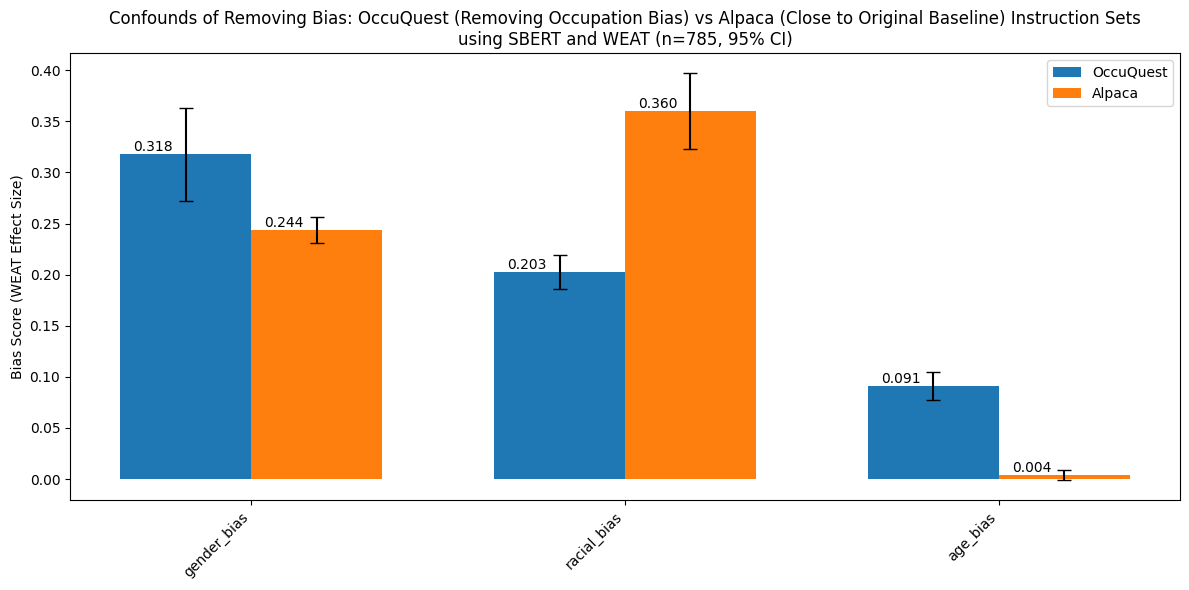

In [84]:
# Create bar chart
fig, ax = plt.subplots(figsize=(12, 6))
x = range(len(bias_types))
width = 0.35

occuquest_bars = ax.bar([i - width/2 for i in x], occuquest_values, width, label='OccuQuest', color='#1f77b4', yerr=occuquest_ci, capsize=5)
alpaca_bars = ax.bar([i + width/2 for i in x], alpaca_values, width, label='Alpaca', color='#ff7f0e', yerr=alpaca_ci, capsize=5)

ax.set_ylabel('Bias Score (WEAT Effect Size)')
ax.set_title(f'Confounds of Removing Bias: OccuQuest (Removing Occupation Bias) vs Alpaca (Close to Original Baseline) Instruction Sets\nusing SBERT and WEAT (n={sample_size}, 95% CI)')
ax.set_xticks(x)
ax.set_xticklabels(bias_types, rotation=45, ha='right')
ax.legend()

# Add value labels on the bars
def add_value_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/4., height,
                f'{height:.3f}',
                ha='center', va='bottom', rotation=0)

add_value_labels(occuquest_bars)
add_value_labels(alpaca_bars)

# Adjust layout and display
plt.tight_layout()
plt.show()



In [27]:
# Print numerical results for reference
print("Bias Scores (WEAT Effect Size):")
for bias_type in bias_types:
    print(f"{bias_type}:")
    print(f"  OccuQuest: {occuquest_bias[bias_type]:.4f}")
    print(f"  Alpaca: {alpaca_bias[bias_type]:.4f}")

Dataset({
    features: ['category', 'occupation', 'topic', 'messages'],
    num_rows: 3140
})
